# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [1]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


In [26]:
#klasa abstrakcyjna, po której będą dziedziczyć pozostałe klasy, ma metody abstrakcyjne backward i foward
# i metodę do ustawiania learning_rate
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

# klasa reprezentująca w pełni połączoną warstę sieci neuronowej
class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

        # inicjalizujemy losowe wagi międy 0 a 1 oraz bias wypełniony zerami
        self.bias = np.zeros(output_size)
        # wagi to jest macierz o rozmiarach input_size na output_size
        self.weights = np.random.uniform(low=-1, high=1, size=(input_size, output_size))

    # propagacja w przód
    def forward(self, x:np.ndarray)->np.ndarray:
        self.x = x # wektro wejściowy

        # iloczyn macierzowy między wagami a wektorem wejściowym i na końcu dodawany bias
        linear_output = np.dot(x, self.weights) + self.bias

        return linear_output

    # propagacja wsteczna
    def backward(self, output_error_derivative)->np.ndarray:
        # iloczyn maceirzowy pomiędzy gradientem funkcji straty a transponowanym wektorem wejścowym
        derivative_of_weights = np.dot(self.x.T, output_error_derivative)

        # suma gradientów dla każdego neuronu
        derivative_of_bias = np.sum(output_error_derivative, axis=0)

        #gradient względem wejścia warstwy. Iloczyn macierzowy między gradientem funkcji straty, a wagami transpozowanymi
        derivative_of_input_error = np.dot(output_error_derivative, self.weights.T)

        # aktualizujemy wagi i bias
        self.weights -= self.learning_rate * derivative_of_weights
        self.bias -= self.learning_rate * derivative_of_bias

        # zwracamy gradient względem wejścia warstwy
        return derivative_of_input_error

# klasa reprezentujące funkcję aktwacji, w tym wupadku jest to tanges hiperboliczny
class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    # funkcja aktywacji to tanges hiperobliczny, wieć tutaj zwracamy wektor wyjściowy przepuszczony przez funkcję aktywacji
    def forward(self, x:np.ndarray)->np.ndarray:
        self.x = x
        return np.tanh(x)


    def backward(self, output_error_derivative)->np.ndarray:
        # pochodna funkcji aktywacji
        derivative_of_tanh = (1.0 - np.tanh(self.x)**2)

        return derivative_of_tanh * output_error_derivative

# klasa reprezentująca funkcję straty
class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss_func(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function for a particular x and y"""
        return self.loss_function(x, y)

    def loss_derivative_func(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)

# klasa reprezentująca sieć neuronową złożoną z warstw
class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        # każdej wartswie ustawiamy learning rate
        for layer in self.layers:
            layer.learning_rate = learning_rate

        # domyślnie funckją predykcji jest wyciąganie indeksu największej wartości
        self.prediction = lambda output: np.argmax(output)


    def compile(self, loss:Loss, prediction_function: callable = None)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss
        if prediction_function is not  None:
            self.prediction = prediction_function

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        # jeżeli wektor jest jednowymiarowy to zmieniamy go na dwuwymiarowy
        if x.ndim == 1:
            x = x.reshape(1, -1)
        # każdą warstwę propagujemy w przód
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def predict(self, output: np.ndarray) -> np.ndarray:
        # zwraca predykcję, czyli indeks największej wartości
        return self.prediction(output)

    def fit(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int, x_test: np.ndarray = np.empty(0), y_test: np.ndarray = np.empty(0), verbose: int = 0):
        """Fit the network to the training data"""

        # listy przetrzymujące wartości : funkjci straty, dokładności, dokładności na zbiorze testowym w każdej epoce, przyda się do wykresów
        losses, accuracy_train, accuracy_test = [], [], []

        # iterujemy po epokach i dla każdej epoki liczymy : funkcję straty, dokładność na zbiorze testowym i treningowym, bo to się przyda do wykresów
        for epoch in range(epochs):
            # ile było poprawnych przewidzeń
            correct = 0
            # dla danych treningowych
            for x, y in zip(x_train, y_train):
                # propagacja do przodu przez wszystkie warstwy
                output = self(x)

                # liczymy funkcję straty
                loss_output = self.loss.loss_func(output, y)

                # sprawdzamy czy sieć dobrze przewidziała dla danego stopnia wytrenowania
                if self.predict(output) == self.predict(y):
                    correct += 1

                # propagacja wsteczna
                # obliczamy pochodną funkcji straty względem wyjścia sieci
                # iterujemy po warstwach w odwrotnej kolejności
                #liczymy pochodne wag i biasu i błędu na wejściu warstwy, i na ich podstawie aktualizujemy wagi i bias
                loss_derivative = self.loss.loss_derivative_func(output, y)
                for layer in reversed(self.layers):
                    loss_derivative = layer.backward(loss_derivative)

            #sprawdzamy poprawność na danych testowych
            correct_test = 0
            for x, y in zip(x_test, y_test):
                output = self(x)
                if self.predict(output) == self.predict(y):
                    correct_test += 1

            # aktualizacja tablic :
            loss_value = np.sum(loss_output)
            accuracy_on_train = correct / len(x_train)
            accuracy_on_test = correct_test / len(x_test) if len(x_test) != 0 else 0

            if verbose == 1:
                print(f"epoch {epoch+1}/{epochs} - accuracy: {accuracy_on_train:.4f} - loss: {loss_value:.4f}")

            losses.append(loss_value)
            accuracy_train.append(accuracy_on_train)
            accuracy_test.append(accuracy_on_test)

        # return the lists at the end of training
        return losses, accuracy_train, accuracy_test


Funkcje straty :

In [3]:
def mse_loss(x, y):
    return (x - y)**2

def mse_loss_derivative(x, y):
    return 2*(x - y)

mse = Loss(mse_loss, mse_loss_derivative)

# Eksperymenty

BRAMKA XOR : 
--

In [27]:
# dane bramki XOR
x_xor = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
y_xor = np.array([[0], [1], [1], [0]])

# warstwy sieci :
fully_connected1 = FullyConnected(input_size=2, output_size=2)
tanh1 = Tanh()
fully_connected2 = FullyConnected(input_size=2, output_size=1)
tanh2 = Tanh()

# tworzymy sieć z learning_rate = 0.1
network = Network(layers=[fully_connected1, tanh1, fully_connected2, tanh2], learning_rate=0.1)

# funkcja predykcji dla bramki XOR:
def xor_prediction_function(output):
    if np.sum(output) < 0.5:
        return 1
    else:
        return 0

# wołamy i trenujemy sieć
network.compile(mse,xor_prediction_function)

network.fit(x_xor, y_xor, epochs=100, verbose=1)



epoch 1/100 - accuracy: 0.5000 - loss: 0.1463
epoch 2/100 - accuracy: 0.5000 - loss: 0.2334
epoch 3/100 - accuracy: 0.5000 - loss: 0.2655
epoch 4/100 - accuracy: 0.5000 - loss: 0.2720
epoch 5/100 - accuracy: 0.5000 - loss: 0.2640
epoch 6/100 - accuracy: 0.7500 - loss: 0.2465
epoch 7/100 - accuracy: 1.0000 - loss: 0.2218
epoch 8/100 - accuracy: 1.0000 - loss: 0.1915
epoch 9/100 - accuracy: 1.0000 - loss: 0.1575
epoch 10/100 - accuracy: 1.0000 - loss: 0.1223
epoch 11/100 - accuracy: 1.0000 - loss: 0.0889
epoch 12/100 - accuracy: 1.0000 - loss: 0.0605
epoch 13/100 - accuracy: 1.0000 - loss: 0.0386
epoch 14/100 - accuracy: 1.0000 - loss: 0.0233
epoch 15/100 - accuracy: 1.0000 - loss: 0.0136
epoch 16/100 - accuracy: 1.0000 - loss: 0.0077
epoch 17/100 - accuracy: 1.0000 - loss: 0.0043
epoch 18/100 - accuracy: 1.0000 - loss: 0.0024
epoch 19/100 - accuracy: 1.0000 - loss: 0.0013
epoch 20/100 - accuracy: 1.0000 - loss: 0.0007
epoch 21/100 - accuracy: 1.0000 - loss: 0.0004
epoch 22/100 - accurac

([0.14625429460211037,
  0.2333919506768215,
  0.2655342718408848,
  0.2719837385867348,
  0.26404850821240405,
  0.2465427034618447,
  0.22183467717139718,
  0.19154896909680094,
  0.15751359851201904,
  0.12225986395707841,
  0.08892392174958078,
  0.060455221904266915,
  0.03857971947683627,
  0.023346330723119202,
  0.013573217900283282,
  0.007677530856637954,
  0.004269340546696684,
  0.0023536367390443835,
  0.001296085539424372,
  0.0007188211195199021,
  0.00040568157108694447,
  0.0002361044043997542,
  0.00014400602900224425,
  9.363744110251775e-05,
  6.585396116179745e-05,
  5.046519389206419e-05,
  4.2041453633764544e-05,
  3.7651517880796585e-05,
  3.5663751847393195e-05,
  3.512336426643807e-05,
  3.5435682455746864e-05,
  3.620794601782202e-05,
  3.7170678468402125e-05,
  3.813752894416891e-05,
  3.898295994473536e-05,
  3.962795042919863e-05,
  4.002935527612036e-05,
  4.017118426606938e-05,
  4.005721526879866e-05,
  3.9704789212608905e-05,
  3.913974534707277e-05,
 

In [15]:
for x_train, y_train in zip(x_xor, y_xor):
    output = network(x_train)
    print(f"{x_train} => {network.predict(output)}, expected => {y_train[0]}")

[0 0] => 1, expected => 0
[0 1] => 0, expected => 1
[1 1] => 0, expected => 1
[1 0] => 1, expected => 0


MINST
--

In [12]:
# funkcja do ładowania liczb
def digits(state=10):
    small_digits = load_digits() # ładuje dane z sklearn_datasets

    x = small_digits.data / 16  # normalizacja macierzy żeby pixele był w skali 0 do 1

    # Dla każdego przykładu ustawia odpowiednią pozycję w macierzy y na 1 -> klasa cyfry
    y = np.zeros((len(x), 10))

    for i, value in enumerate(y):
        value[small_digits.target[i]] = 1

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=state)
    return x_train, x_test, y_train, y_test


1. Testowanie dokładności do ilości epok dla 1 ukrytej warstwy z 10 neuronami

state: 16, mean_accuracy_test: 0.7562222222222222, mean_accuracy_train: 0.7622546972860126


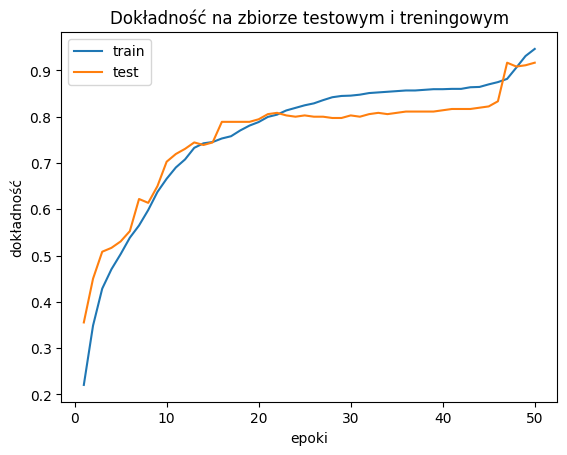

state: 42, mean_accuracy_test: 0.7064444444444444, mean_accuracy_train: 0.7159498956158665


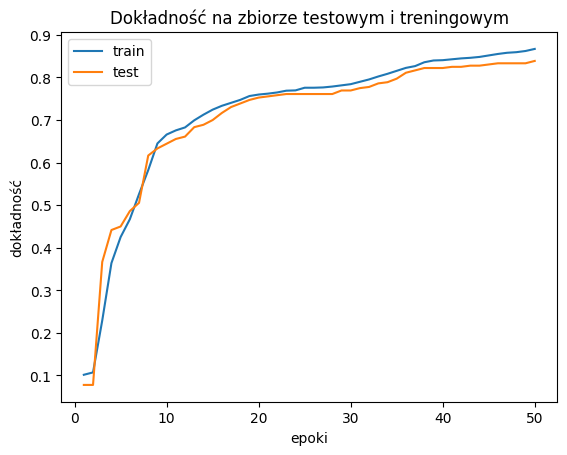

state: 76, mean_accuracy_test: 0.7933333333333331, mean_accuracy_train: 0.8222268615170495


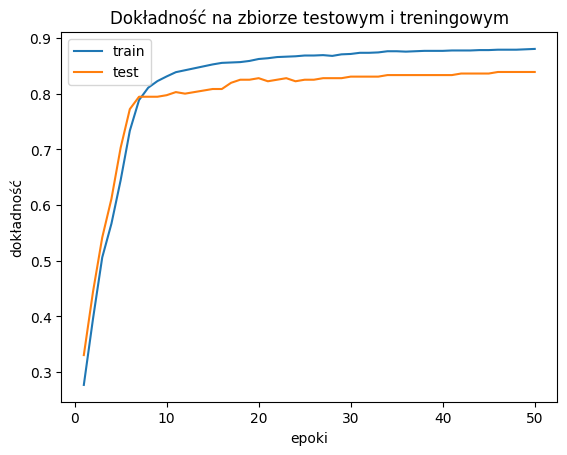

In [22]:
for state in [16, 42, 76]:
    x_train, x_test, y_train, y_test = digits(state) # losujemy dane z tych stanów

    # tworzymy sieć o jednej warstwie ukrytej
    fully_connected_1 = FullyConnected(64, 16)
    tanh1 = Tanh()
    fully_conected_2 = FullyConnected(16, 10)
    tanh2 = Tanh()

    network = Network([fully_connected_1, tanh1, fully_conected_2, tanh2], 0.01)

    # kompilujemy sieć żebby ustawić funkcję straty
    network.compile(mse)

    # trenujemy sieć i zapisujemy wartości funkcji straty, dokładności na zbiorze testowym i treningowym
    losses, accuracy_train, accuracy_test = network.fit(x_train, y_train, 50, x_test, y_test, 2)

    # średnie z całego treningu
    print(f"state: {state}, mean_accuracy_test: {np.mean(accuracy_test)}, mean_accuracy_train: {np.mean(accuracy_train)}")
    # wykres dokładności na zbiorze testowym i treningowym
    epoki = np.arange(1, 51)
    plt.plot(epoki, accuracy_train, label="train")
    plt.plot(epoki, accuracy_test, label="test")
    plt.title("Dokładność na zbiorze testowym i treningowym")
    plt.xlabel("epoki")
    plt.ylabel("dokładność")
    plt.legend()
    plt.show()

2. Testowanie dokładności do ilości epok dla 2 ukrytych warstw z 10 neuronami

state: 16, mean_accuracy_test: 0.8001666666666668, mean_accuracy_train: 0.8163117606123869


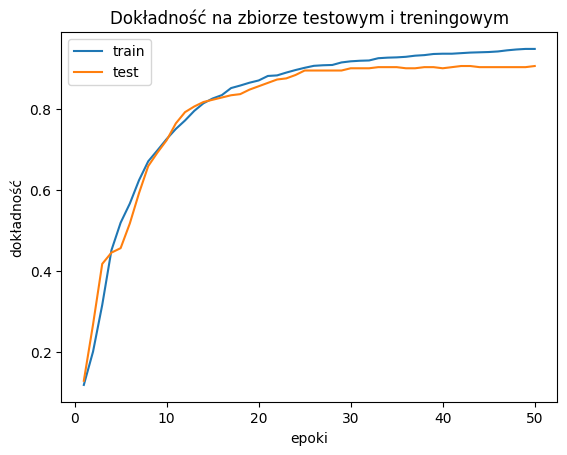

state: 42, mean_accuracy_test: 0.7986666666666664, mean_accuracy_train: 0.7847181628392483


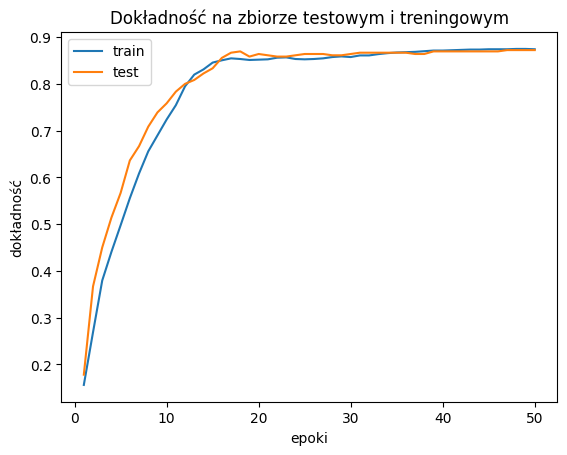

state: 76, mean_accuracy_test: 0.7757222222222221, mean_accuracy_train: 0.7732915796798885


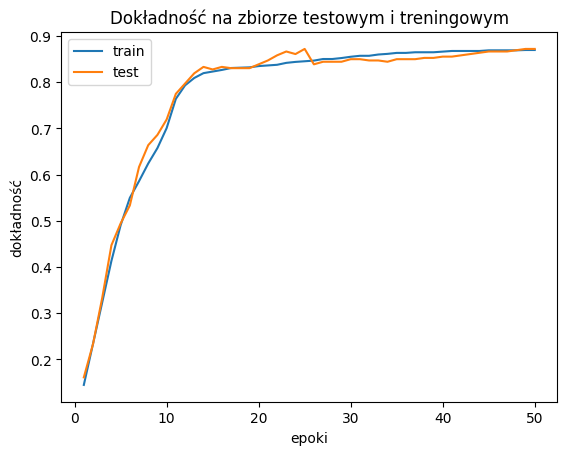

In [195]:
for state in [16, 42, 76]:
    x_train, x_test, y_train, y_test = digits(state)

    fully_connected_1 = FullyConnected(64, 16)
    tanh1 = Tanh()
    fully_conected_2 = FullyConnected(16, 10)
    tanh2 = Tanh()
    fully_conected_3 = FullyConnected(10, 10)
    tanh3 = Tanh()

    network = Network([fully_connected_1, tanh1, fully_conected_2, tanh2, fully_conected_3, tanh3], 0.01)

    network.compile(mse)

    losses, accuracy_train, accuracy_test = network.fit(x_train, y_train, 50, x_test, y_test, 2)

    print(f"state: {state}, mean_accuracy_test: {np.mean(accuracy_test)}, mean_accuracy_train: {np.mean(accuracy_train)}")

    # wykres dokładności na zbiorze testowym i treningowym
    epoki = np.arange(1, 51)
    plt.plot(epoki, accuracy_train, label="train")
    plt.plot(epoki, accuracy_test, label="test")
    plt.title("Dokładność na zbiorze testowym i treningowym")
    plt.xlabel("epoki")
    plt.ylabel("dokładność")
    plt.legend()
    plt.show()

3. Testowanie dokładności do ilości epok dla 3 ukrytych warstw 

state: 16, mean_accuracy_test: 0.7163333333333333, mean_accuracy_train: 0.7116910229645095


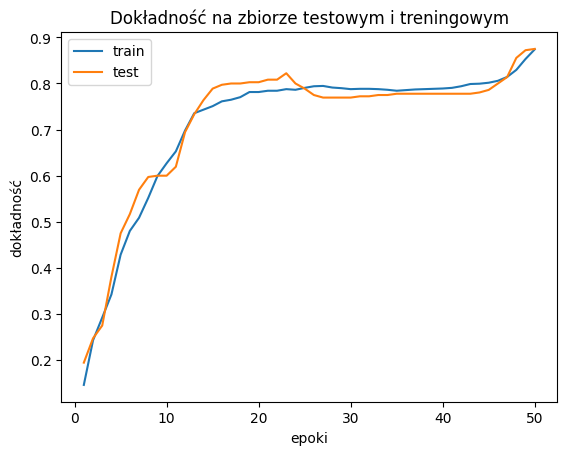

state: 42, mean_accuracy_test: 0.8227222222222222, mean_accuracy_train: 0.832651356993737


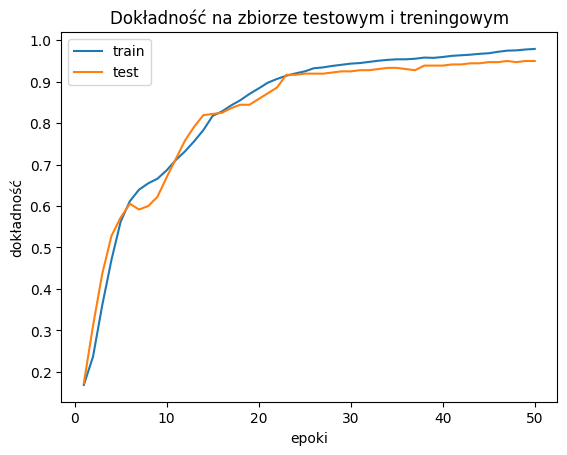

state: 76, mean_accuracy_test: 0.7137777777777776, mean_accuracy_train: 0.7167014613778706


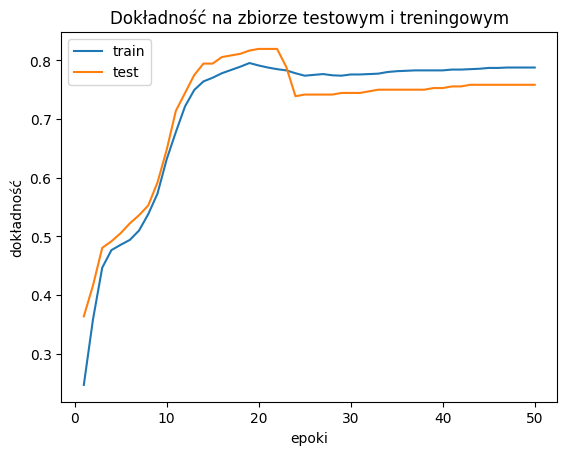

In [218]:
for state in [16, 42, 76]:
    x_train, x_test, y_train, y_test = digits(state)

    fully_connected_1 = FullyConnected(64, 16)
    tanh1 = Tanh()
    fully_conected_2 = FullyConnected(16, 16)
    tanh2 = Tanh()
    fully_conected_3 = FullyConnected(16, 10)
    tanh3 = Tanh()
    fully_conected_4 = FullyConnected(10, 10)
    tanh4 = Tanh()

    network = Network([fully_connected_1, tanh1, fully_conected_2, tanh2, fully_conected_3, tanh3, fully_conected_4, tanh4], 0.01)

    network.compile(mse)

    losses, accuracy_train, accuracy_test = network.fit(x_train, y_train, 50, x_test, y_test, 2)

    print(f"state: {state}, mean_accuracy_test: {np.mean(accuracy_test)}, mean_accuracy_train: {np.mean(accuracy_train)}")

    # wykres dokładności na zbiorze testowym i treningowym
    epoki = np.arange(1, 51)
    plt.plot(epoki, accuracy_train, label="train")
    plt.plot(epoki, accuracy_test, label="test")
    plt.title("Dokładność na zbiorze testowym i treningowym")
    plt.xlabel("epoki")
    plt.ylabel("dokładność")
    plt.legend()
    plt.show()

Przeprowadziliśmy badania na tych samych setach dla architektury 1-warstwowej, 2- warstwowej i 3-warstwowej:
- wyniki nie różnią się dużo, jednak widać, że jednowarstwowa wypadła najlepiej ze wszystkich
- zwiększając ilość warstw ukrytych widzimy spadek jakości działania sieci
- 1-2 warstw ukrytych wystarczy dla naszego problemu i daje zadowalające wyniki w okolicach 80%

4. Testowanie dokładności względem learning_rate dla 1 ukrytej warstwy  z 10 neuronami

state: 16


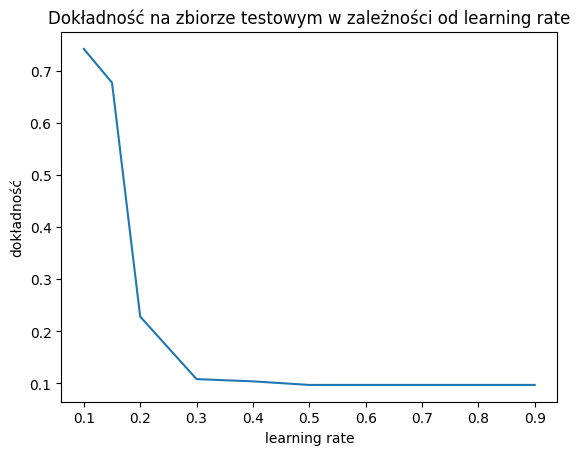

state: 42


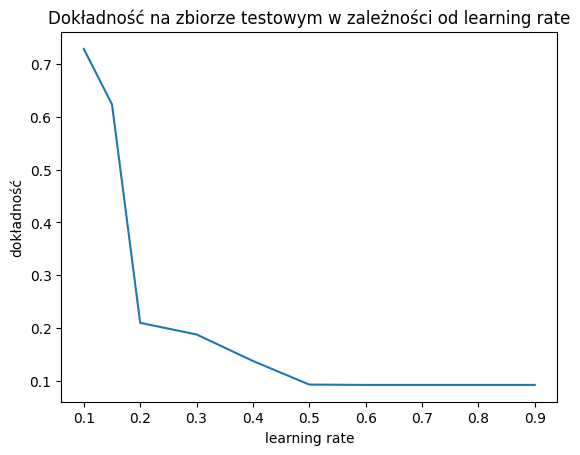

state: 76


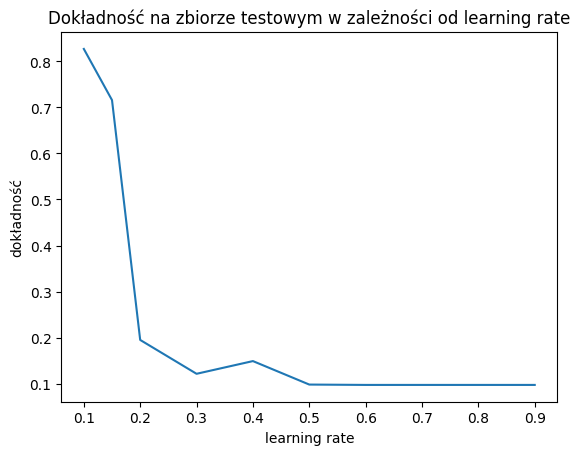

In [191]:
for state in [16, 42, 76]:
    x_train, x_test, y_train, y_test = digits(state)

    learning_rates = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    accuracy = []
    fully_connected_1 = FullyConnected(64, 16)
    fully_conected_2 = FullyConnected(16, 10)
    tanh1 = Tanh()
    tanh2 = Tanh()
    for learning_rate in learning_rates:
        network = Network([fully_connected_1, tanh1, fully_conected_2, tanh2], learning_rate)

        network.compile(mse)
        losses, accuracy_train, accuracy_test = network.fit(x_train, y_train, 50, x_test, y_test, 0)
        mean_accuracy = np.sum(accuracy_test)/len(accuracy_test)
        accuracy.append(mean_accuracy)

    print(f"state: {state}")
    plt.plot(learning_rates, accuracy)
    plt.title("Dokładność na zbiorze testowym w zależności od learning rate")
    plt.xlabel("learning rate")
    plt.ylabel("dokładność")
    plt.show()

Badaliśmy wpływ learning rat'u na skuteczność uczenia się sieci :
- dla mniejszych wartości learning rate'u widać, że sieć uczyła się dosyć skutecznie
- zwiększając leraning rate, następował spadek jakości sieci i wyniki przestały się pokrwać w dużym stopniu
- Mniejszy learning rate jest lepszy i powoduje większą skuteczność 

4. Na całym zbiorze MIST (dużym)

In [212]:
def normal_digits(state=20):
    digits = fetch_openml('mnist_784', version=1, parser='auto') # ładujemy dane z sklearn_datasets
    x = digits.data.to_numpy() / 255    # normalizacja macierzy żeby pixele był w skali 0 do 1
    y = np.zeros((len(x), 10))

    # dla każdego przykładu ustawiamy odpowiednią pozycję w macierzy y na 1 -> klasa cyfry
    for i, value in enumerate(y):
        value[int(digits.target.to_numpy()[i])] = 1

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=state)
    return x_train, x_test, y_train, y_test

epoch 1/50 - accuracy: 0.6255 - loss: 1.0807
epoch 2/50 - accuracy: 0.7678 - loss: 1.1978
epoch 3/50 - accuracy: 0.8170 - loss: 0.8688
epoch 4/50 - accuracy: 0.8642 - loss: 0.3878
epoch 5/50 - accuracy: 0.8731 - loss: 0.5236
epoch 6/50 - accuracy: 0.8797 - loss: 0.4873
epoch 7/50 - accuracy: 0.8832 - loss: 0.8184
epoch 8/50 - accuracy: 0.8853 - loss: 0.7061
epoch 9/50 - accuracy: 0.8888 - loss: 0.7714
epoch 10/50 - accuracy: 0.8916 - loss: 0.6574
epoch 11/50 - accuracy: 0.8932 - loss: 0.7779
epoch 12/50 - accuracy: 0.8943 - loss: 0.5846
epoch 13/50 - accuracy: 0.8963 - loss: 0.8597
epoch 14/50 - accuracy: 0.8977 - loss: 0.6787
epoch 15/50 - accuracy: 0.8989 - loss: 0.5869
epoch 16/50 - accuracy: 0.8997 - loss: 0.1885
epoch 17/50 - accuracy: 0.9010 - loss: 0.8676
epoch 18/50 - accuracy: 0.9012 - loss: 0.2160
epoch 19/50 - accuracy: 0.9029 - loss: 0.9028
epoch 20/50 - accuracy: 0.9040 - loss: 0.8849
epoch 21/50 - accuracy: 0.9048 - loss: 0.7798
epoch 22/50 - accuracy: 0.9059 - loss: 0.62

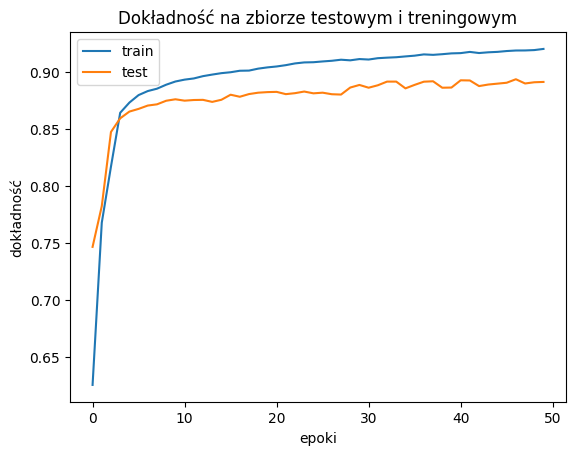

In [214]:
x_train, x_test, y_train, y_test = normal_digits(20)

fully_connected_1 = FullyConnected(784, 16)
tanh1 = Tanh()
fully_conected_2 = FullyConnected(16, 16)
tanh2 = Tanh()
fully_conected_3 = FullyConnected(16, 10)
tanh3 = Tanh()

network = Network([fully_connected_1, tanh1, fully_conected_2, tanh2, fully_conected_3, tanh3], 0.01)

network.compile(mse)

losses, accuracy_train, accuracy_test = network.fit(x_train, y_train, 50, x_test, y_test, 1)

print(f"state: {20}, mean_accuracy_test: {np.mean(accuracy_test)}, mean_accuracy_train: {np.mean(accuracy_train)}")
plt.plot(accuracy_train, label="train")
plt.plot(accuracy_test, label="test")
plt.title("Dokładność na zbiorze testowym i treningowym")
plt.xlabel("epoki")
plt.ylabel("dokładność")
plt.legend()
plt.show()

- Użyliśmy tutaj większego datasetu, co sprawiło, że uczenie sięsieci trwało strasznie długo. Dlatego lepiej jest używać mniejszych zestawów

Wnioski
--

- Jeżeli krzywa na której trenujemy model jest większa od krzywej na której testujemy -> może być nadmiernie dopasowany do danych treningowych więc mamy overfitting Widzimy go np. gdy mamy dużo epok
- Jeżeli mamy mał accuracy i krzywe są blisko siebie to mamy underfitting, model nie jest w stanie dobrze się dopasować do danych treningowych ani generalizować dobrze dane testowe -> gdy mamy za mało epok
- Najlepszy wydaje się w wypadkach testowych przedział 10-20 epok (dla małych setów), oraz w okolicahc 8 dla dużego setu ponieważ wtedy nie występuje over- ani underfitting (albo jest w najmniejszym stopniu)